<a href="https://colab.research.google.com/github/dafeRoy/pytorch_projects/blob/main/image_classification_pretained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# A pretrained model is a model already trained on several tasks, and doing modification so the model
# uses it´s old knowledge to solve new problems (Transfer Learning)

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: d_roy71@yahoo.co.uk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.11GB/s]

In [3]:
import torch # Main PyTorch Library
import torch.nn as nn # Used for creating the layers and loss function
from torchvision import models, transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

In [4]:

# The following code will be going through a nested directory structure where images are stored
# within subdirectories, each directory is representing a specific label (category). It constructs
# a list of the file paths for these images and their corresponding labels. Then, it creates a pandas
# DataFrame containing this information, which is useful for further data processing.

train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

df = pd.concat([train_df, val_df], ignore_index=True)
df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + df["image:FILE"]

df

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0
...,...,...
1162,/content/bean-leaf-lesions-classification/val/...,2
1163,/content/bean-leaf-lesions-classification/val/...,2
1164,/content/bean-leaf-lesions-classification/val/...,2
1165,/content/bean-leaf-lesions-classification/val/...,2


In [5]:
# data inspection
df["category"].value_counts()

,count
category,
2,393
1,389
0,385


In [6]:
# data split
# since we will be reading the image paths from df, it is better we split the df directly and then read the images

train = df.sample(frac=0.7, random_state=42) # 70% of the data for training
test = df.drop(train.index) # Create test data by removing the train data

In [7]:
train

,image:FILE,category
694,/content/bean-leaf-lesions-classification/trai...,2
1115,/content/bean-leaf-lesions-classification/val/...,1
58,/content/bean-leaf-lesions-classification/trai...,0
70,/content/bean-leaf-lesions-classification/trai...,0
1030,/content/bean-leaf-lesions-classification/trai...,2
...,...,...
1151,/content/bean-leaf-lesions-classification/val/...,2
489,/content/bean-leaf-lesions-classification/trai...,1
154,/content/bean-leaf-lesions-classification/trai...,0
638,/content/bean-leaf-lesions-classification/trai...,1


In [8]:
label_encoder = LabelEncoder() # Encode the string classes to numeric
label_encoder.fit(df['category']) # Fit the label encoder on our own data

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

In [9]:
# custom dataset class

# We will not read each image inside the constructor as reading images here will be so time consuming.
# However, we are reading each image, applying the preprocessing and returning it in the __getitem__ .

class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(df['category'])) # Encode the labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index, 0]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)/255

        return image, label

In [10]:
# create dataset objects for training and testing

train_dataset = CustomImageDataset(df=train, transform=transform)
test_dataset = CustomImageDataset(df=test, transform=transform)

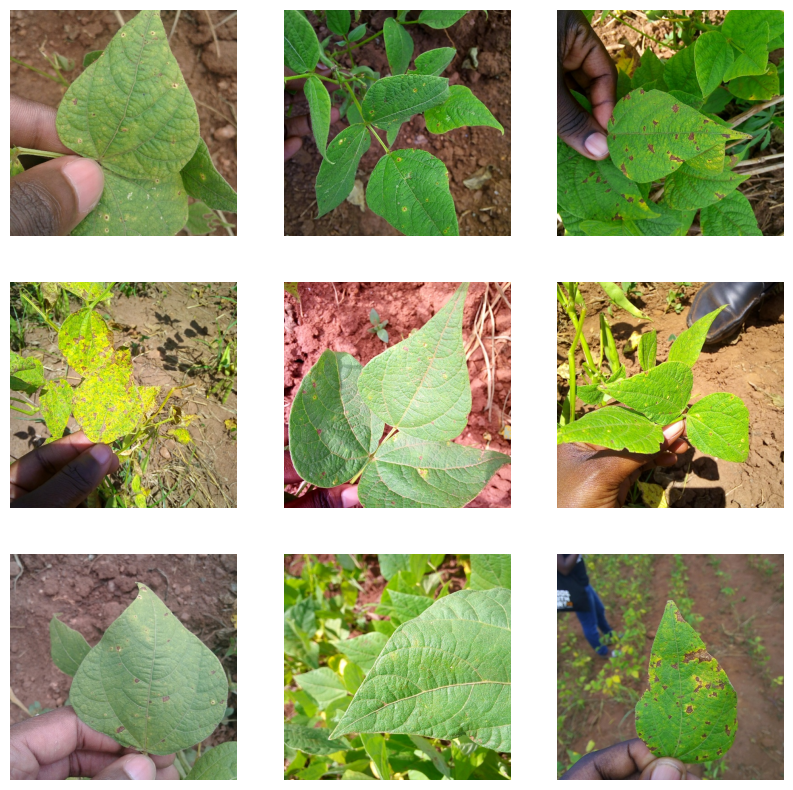

In [11]:
# visualizing images just to see what they look like
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(1)['image:FILE'].iloc[0]).convert('RGB')
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
plt.show()

In [12]:
# hyperparameters
LR = 1e-4
BATCH_SIZE = 4
EPOCHS = 15

In [22]:
# dataloaders

# When we train, we loop through epochs, in batches for efficiency instead of looping through all the training data at once.
# Dataloader allows you to loop through the batches easily during the training. You define the batch size and enable
# shuffle to randomize the data and then you can loop through it in each epoch to train normally.

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
# model
# we will be using a pretrained model (googlenet) from pytorch library

googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = True

googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [24]:
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, len(label_encoder.classes_))
googlenet_model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [25]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet_model.parameters(), lr=LR)

In [26]:
# training
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    ## Training
    for inputs, labels in train_loader:
        prediction = googlenet_model(inputs)
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()

        acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))

    print(f"Epoch no. {epoch + 1}/{EPOCHS} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(train_dataset.__len__())*100):.4f}%")
    print()

Epoch no. 1/15 Train Loss: 0.1860 Train Accuracy: 56.3035%

Epoch no. 2/15 Train Loss: 0.1389 Train Accuracy: 72.0930%

Epoch no. 3/15 Train Loss: 0.1184 Train Accuracy: 76.4994%

Epoch no. 4/15 Train Loss: 0.1038 Train Accuracy: 80.4162%

Epoch no. 5/15 Train Loss: 0.0911 Train Accuracy: 81.3953%

Epoch no. 6/15 Train Loss: 0.0805 Train Accuracy: 86.0465%

Epoch no. 7/15 Train Loss: 0.0612 Train Accuracy: 90.5753%

Epoch no. 8/15 Train Loss: 0.0595 Train Accuracy: 88.9841%

Epoch no. 9/15 Train Loss: 0.0600 Train Accuracy: 89.7185%

Epoch no. 10/15 Train Loss: 0.0526 Train Accuracy: 91.6769%

Epoch no. 11/15 Train Loss: 0.0520 Train Accuracy: 92.1665%

Epoch no. 12/15 Train Loss: 0.0424 Train Accuracy: 94.0024%

Epoch no. 13/15 Train Loss: 0.0412 Train Accuracy: 93.8800%

Epoch no. 14/15 Train Loss: 0.0387 Train Accuracy: 94.6144%

Epoch no. 15/15 Train Loss: 0.0360 Train Accuracy: 94.1248%



In [27]:
# evaluate model on test data set
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = googlenet_model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 2)}% and Loss is {round(total_loss_test/1000, 4)}")



Accuracy Score is: 80.0% and Loss is 0.0525


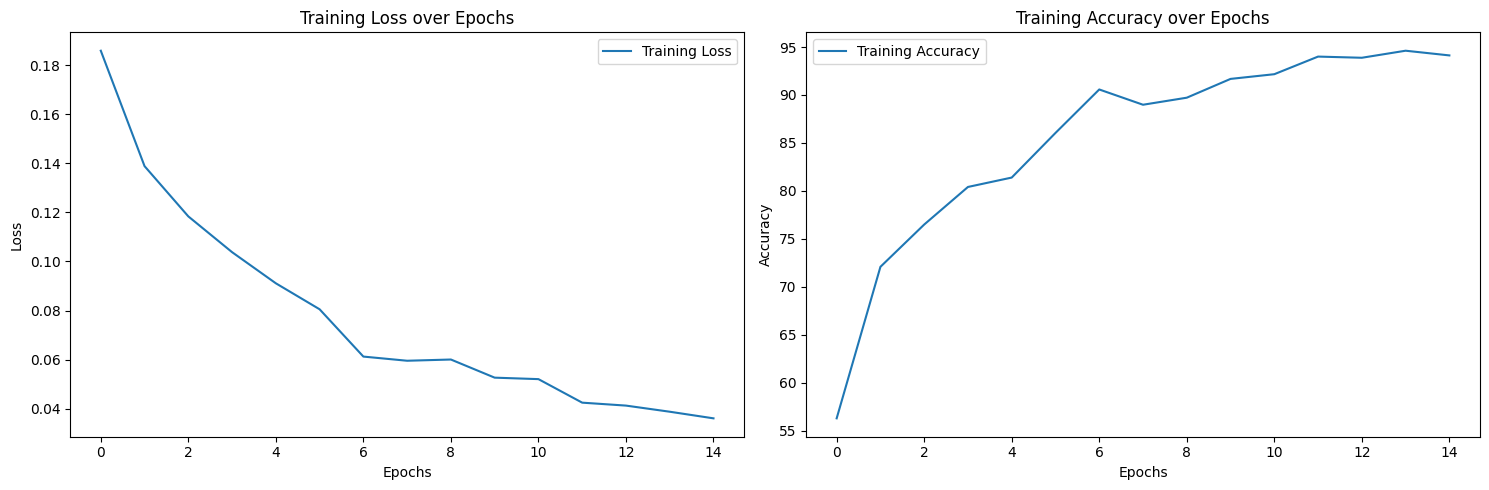

In [28]:
# plotting and visualization
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()